In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import os
import glob
import guitarpro
import librosa, soundfile, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy
from utils import *
from operations import *

## Break multi-track gtp files into single-track gtp files
generate clean_single_track_gtps, which contain gtp files that have:
* unified volume, 
* clean guitar tone, 
* no repeats,
* no mixTableChanges
This behaviour is implemented as default in `operations.get_single_tracks`

In [ ]:
MULTI_TRACK_DIR = "/Volumes/MacOnly/UG_raw/all_time_top_by_hits"
# clean_single_track_gtps contains gtp files that have:
# unified volume, clean guitar tone, no repeats, no mixTableChanges
CLEAN_SINGLE_TRACK_DIR = (
    "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/clean_single_track_gtps"
)

i = 0
for file in glob.glob(os.path.join(MULTI_TRACK_DIR, "*.gp*")):
    i += 1
    print(f"processing file {i}: {file.split('/')[-1]}")
    get_single_tracks(file=file, output_dir=CLEAN_SINGLE_TRACK_DIR)



## Segment single-track audio into poly and mono segments (GT)

In [4]:
# a test
file_name = "DragonForce - Through The Fire And Flames_Lead 2.gp5"
song = guitarpro.parse(os.path.join(CLEAN_SINGLE_TRACK_DIR, file_name))
poly, mono = poly_vs_mono(song)


In [5]:
poly


[[37.2, 38.400000000000006],
 [288.6, 289.2],
 [289.8, 290.4],
 [414.0, 418.79999999999995]]

In [6]:
mono


[[0.0, 37.2],
 [38.4, 288.59999999999997],
 [289.2, 289.8],
 [290.4, 414.0],
 [418.8, 433.2]]

In [ ]:
CLEAN_SINGLE_TRACK_DIR = (
    "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/clean_single_track_gtps"
)
SINGLE_TRACK_AUDIO_DIR = (
    "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/clean_single_track_audio"
)
POLY_SEGMENTS_DIR = "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/poly_audio_segments"
MONO_SEGMENTS_DIR = "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/mono_audio_segments"

i = 0
for file in glob.glob(os.path.join(CLEAN_SINGLE_TRACK_DIR, "*.gp5")):
    i += 1
    track_title, _ = os.path.splitext(file.split("/")[-1])
    print(f"processing file {i}: {track_title}")

    song = guitarpro.parse(file)
    poly, mono = poly_vs_mono(song)

    y, sr = librosa.load(
        os.path.join(SINGLE_TRACK_AUDIO_DIR, track_title + ".wav"), sr=None, mono=True
    )

    for j, poly_segment in enumerate(poly):
        start_sec = poly_segment[0]
        end_sec = poly_segment[1]
        segment = y[int(start_sec * sr) : int(end_sec * sr)]
        # write segment to file, store it in the "poly" folder
        segment_file_name = "{}_{}_{}s.wav".format(
            track_title, j, int(start_sec)
        )
        soundfile.write(os.path.join(POLY_SEGMENTS_DIR, segment_file_name), segment, sr)

    for j, mono_segment in enumerate(mono):
        start_sec = mono_segment[0]
        end_sec = mono_segment[1]
        segment = y[int(start_sec * sr) : int(end_sec * sr)]
        # write segment to file, store it in the "mono" folder
        segment_file_name = "{}_{}_{}s.wav".format(track_title, j, int(start_sec))
        soundfile.write(os.path.join(MONO_SEGMENTS_DIR, segment_file_name), segment, sr)



## Generate frames (features and labels) from the poly and mono segments

### Mel-spectrum

In [ ]:
# frame-level features: mel-spectrum (compute via mel-spectrogram)
FRAME_SIZE = 2048
HOP_SIZE = 2048
MONO_LABEL = 0

MONO_SEGMENTS_DIR = "/content/mono_audio_segments"

i = 0
features_with_label = []

for file in glob.glob(os.path.join(MONO_SEGMENTS_DIR, "*.wav")):
    i += 1
    title, _ = os.path.splitext(file.split("/")[-1])
    print(f"processing file {i}: {title}")

    y, sr = librosa.load(file, sr=None, mono=True)
    mel_spec = librosa.feature.melspectrogram(y, sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, center=False)

    no_frames = mel_spec.shape[1]
    columns_to_delete = []

    for j in range(no_frames):
        if np.all(mel_spec[:, j] == 0):
            columns_to_delete.append(j)
    mel_spec = np.delete(mel_spec, columns_to_delete, axis=1)
    print(f"deleted {len(columns_to_delete)} empty frames")
    # zero for mono
    label = np.zeros((1, mel_spec.shape[1]))
    feature_with_label = np.append(mel_spec, label, axis=0)
    features_with_label.append(feature_with_label)

mono_data = np.concatenate(features_with_label, axis=1)
mono_data.shape # (129, 626587)

In [43]:
np.savez_compressed("/content/drive/MyDrive/THESIS CODE/mono.npz", mono_data)   # ~300M
# np.save("/content/drive/MyDrive/THESIS CODE/mono.npy", mono_data)   # ~600M

In [ ]:
# frame-level features: mel-spectrum (compute via mel-spectrogram)
FRAME_SIZE = 2048
HOP_SIZE = 2048
POLY_LABEL = 1

POLY_SEGMENTS_DIR = "/content/poly_audio_segments"

i = 0
features_with_label = []

for file in glob.glob(os.path.join(POLY_SEGMENTS_DIR, "*.wav")):
    i += 1
    title, _ = os.path.splitext(file.split("/")[-1])
    print(f"processing file {i}: {title}")

    y, sr = librosa.load(file, sr=None, mono=True)
    mel_spec = librosa.feature.melspectrogram(y, sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, center=False)

    no_frames = mel_spec.shape[1]
    columns_to_delete = []

    for j in range(no_frames):
        if np.all(mel_spec[:, j] == 0):
            columns_to_delete.append(j)
    mel_spec = np.delete(mel_spec, columns_to_delete, axis=1)
    print(f"deleted {len(columns_to_delete)} empty frames")
    # one for poly
    label = np.ones((1, mel_spec.shape[1]))
    feature_with_label = np.append(mel_spec, label, axis=0)
    features_with_label.append(feature_with_label)

poly_data = np.concatenate(features_with_label, axis=1)
poly_data.shape # (129, 551288)

In [ ]:
np.savez_compressed("/content/drive/MyDrive/THESIS CODE/poly.npz", poly_data)

### MFCC
Parameters: n_mels (40 seems better than default 20), fmax (default 22050 seems better than 8000)

In [ ]:
# frame-level features: MFCC (compute via MFCC)
FRAME_SIZE = 2048
HOP_SIZE = 2048
MONO_LABEL = 0

MONO_SEGMENTS_DIR = "/content/mono_audio_segments"

i = 0
features_with_label = []

for file in glob.glob(os.path.join(MONO_SEGMENTS_DIR, "*.wav")):
    i += 1
    title, _ = os.path.splitext(file.split("/")[-1])
    print(f"processing file {i}: {title}")

    y, sr = librosa.load(file, sr=None, mono=True)
    mel_spec = librosa.feature.melspectrogram(y, sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, center=False)
    # compute MFCC
    log_mel_spec = librosa.power_to_db(mel_spec)
    mfcc = librosa.feature.mfcc(S=log_mel_spec)

    assert (mel_spec.shape[1] == mfcc.shape[1])
    no_frames = mfcc.shape[1]
    columns_to_delete = []

    for j in range(no_frames):
        if np.all(mel_spec[:, j] == 0):
            columns_to_delete.append(j) 

    mfcc = np.delete(mfcc, columns_to_delete, axis=1)
    print(f"deleted {len(columns_to_delete)} empty frames")
    # zero for mono
    label = np.zeros((1, mfcc.shape[1]))
    feature_with_label = np.append(mfcc, label, axis=0)
    features_with_label.append(feature_with_label)

mono_data = np.concatenate(features_with_label, axis=1)
print(mono_data.shape) # (21, 626587)
np.savez_compressed("/content/drive/MyDrive/THESIS CODE/mono_mfcc.npz", mono_data)


In [ ]:
# frame-level features: MFCC (compute via MFCC)
FRAME_SIZE = 2048
HOP_SIZE = 2048
POLY_LABEL = 1

POLY_SEGMENTS_DIR = "/content/poly_audio_segments"

i = 0
features_with_label = []

for file in glob.glob(os.path.join(POLY_SEGMENTS_DIR, "*.wav")):
    i += 1
    title, _ = os.path.splitext(file.split("/")[-1])
    print(f"processing file {i}: {title}")

    y, sr = librosa.load(file, sr=None, mono=True)
    mel_spec = librosa.feature.melspectrogram(y, sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, center=False)
    # compute MFCC
    log_mel_spec = librosa.power_to_db(mel_spec)
    mfcc = librosa.feature.mfcc(S=log_mel_spec)

    assert (mel_spec.shape[1] == mfcc.shape[1])
    no_frames = mel_spec.shape[1]
    columns_to_delete = []

    for j in range(no_frames):
        if np.all(mel_spec[:, j] == 0):
            columns_to_delete.append(j)
    mfcc = np.delete(mfcc, columns_to_delete, axis=1)
    print(f"deleted {len(columns_to_delete)} empty frames")
    # one for poly
    label = np.ones((1, mfcc.shape[1]))
    feature_with_label = np.append(mfcc, label, axis=0)
    features_with_label.append(feature_with_label)

poly_data = np.concatenate(features_with_label, axis=1)
print(poly_data.shape) # (21, 551288)
np.savez_compressed("/content/drive/MyDrive/THESIS CODE/poly_mfcc.npz", poly_data)

## Feature visualization

### Mel spectrum
Tuning the fmax and n_mels didn't help the classifier\
Clipping the spectrum (use up to 8kHz) helped a bit (maybe try some other upper limits?)\
Adding a peak_count feature helped a bit

In [29]:
plt.rcParams["figure.figsize"] = (10, 10)

[Text(0.5, 1.0, 'poly')]

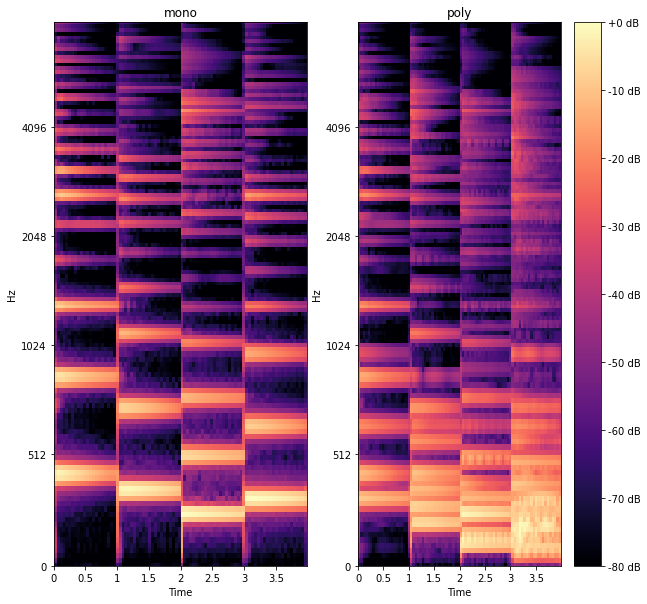

In [27]:
# mel spectrum is computed using the mel spectrogram in librosa
# here we visually compare the mel spectrogram of mono and poly segments
mono_example = "notes.wav"
poly_example = "chords.wav"
y_mono, sr = librosa.load(mono_example, sr=None, mono=True)
y_poly, sr_poly = librosa.load(poly_example, sr=None, mono=True)
assert(sr == sr_poly)

FRAME_SIZE = 2048
HOP_SIZE = 2048
F_MAX = 8000

mel_mono = librosa.feature.melspectrogram(y_mono, sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, center=False, fmax=F_MAX)
mel_poly = librosa.feature.melspectrogram(y_poly, sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, center=False, fmax=F_MAX)

fig, axs = plt.subplots(1, 2)
mel_mono_dB = librosa.power_to_db(mel_mono, ref=np.max)
mel_poly_dB = librosa.power_to_db(mel_poly, ref=np.max)
mono_img = librosa.display.specshow(mel_mono_dB, x_axis='time', y_axis='mel', hop_length=HOP_SIZE, sr=sr, fmax=F_MAX, ax=axs[0])
poly_img = librosa.display.specshow(mel_poly_dB, x_axis='time', y_axis='mel', hop_length=HOP_SIZE, sr=sr, fmax=F_MAX, ax=axs[1])
fig.colorbar(poly_img, ax=axs[1], format='%+2.0f dB')
axs[0].set(title='mono')
axs[1].set(title='poly')


[Text(0.5, 1.0, 'mute_poly')]

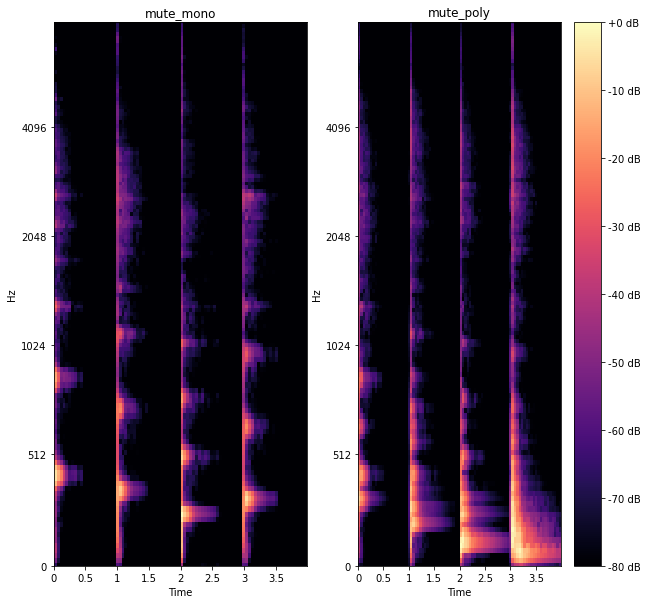

In [42]:
# mel spectrum is computed using the mel spectrogram in librosa
# here we visually compare the mel spectrogram of mono and poly segments
mono_example = "mute_notes.wav"
poly_example = "mute_chords.wav"
y_mono, sr = librosa.load(mono_example, sr=None, mono=True)
y_poly, sr_poly = librosa.load(poly_example, sr=None, mono=True)
assert(sr == sr_poly)

FRAME_SIZE = 2048
HOP_SIZE = 2048
F_MAX = 8000

mel_mono = librosa.feature.melspectrogram(y_mono, sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, center=False, fmax=F_MAX)
mel_poly = librosa.feature.melspectrogram(y_poly, sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, center=False, fmax=F_MAX)

fig, axs = plt.subplots(1, 2)
mel_mono_dB = librosa.power_to_db(mel_mono, ref=np.max)
mel_poly_dB = librosa.power_to_db(mel_poly, ref=np.max)
mono_img = librosa.display.specshow(mel_mono_dB, x_axis='time', y_axis='mel', hop_length=HOP_SIZE, sr=sr, fmax=F_MAX, ax=axs[0])
poly_img = librosa.display.specshow(mel_poly_dB, x_axis='time', y_axis='mel', hop_length=HOP_SIZE, sr=sr, fmax=F_MAX, ax=axs[1])
fig.colorbar(poly_img, ax=axs[1], format='%+2.0f dB')
axs[0].set(title='mute_mono')
axs[1].set(title='mute_poly')


In [34]:
# count the number of peaks in mono and poly spectra
mono_example = "notes.wav"
poly_example = "chords.wav"
y_mono, sr = librosa.load(mono_example, sr=None, mono=True)
y_poly, sr = librosa.load(poly_example, sr=None, mono=True)

FRAME_SIZE = 2048
HOP_SIZE = 2048
F_MAX = 8000

mel_mono = librosa.feature.melspectrogram(y_mono, sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, center=False, fmax=F_MAX)
mel_poly = librosa.feature.melspectrogram(y_poly, sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, center=False, fmax=F_MAX)

print(mel_mono.shape)
print(mel_poly.shape)


(128, 86)
(128, 86)


In [35]:
mel_mono = mel_mono.transpose()
mel_poly = mel_poly.transpose()

In [ ]:
for spectrum in mel_mono:
    # spectrum = spectrum / max(spectrum)
    peaks, _ = scipy.signal.find_peaks(spectrum, height=np.mean(spectrum))
    print(len(peaks))

In [ ]:
for spectrum in mel_poly:
    # spectrum = spectrum / max(spectrum)
    peaks, _ = scipy.signal.find_peaks(spectrum, height=np.mean(spectrum))
    print(len(peaks))

In [ ]:
peak_counts = np.zeros_like(y) # # (1177875,)
for i in range(X.shape[0]):
    # spectrum = spectrum / max(spectrum)
    spectrum = X[i]
    assert(spectrum.shape==(128,))
    peaks, _ = scipy.signal.find_peaks(spectrum, height=np.mean(spectrum))
    peak_counts[i] = len(peaks)
peak_counts_reshaped = np.expand_dims(peak_counts, axis=1) # (1177875, 1)

X_new = np.append(X, peak_counts_reshaped, axis=1) # (1177875, 129)

### Mel cepstrum

In [35]:
# mel cepstrum is computed using the MFCC
# MFCC can be computed from either the audio signal or its log power mel-spectrogram
FRAME_SIZE = 2048
HOP_SIZE = 2048
F_MAX = 8000

y, sr = librosa.load("notes.wav", sr=None, mono=True)
mfcc1 = librosa.feature.mfcc(y, sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, center=False, fmax=F_MAX)

S = librosa.feature.melspectrogram(y, sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, center=False, fmax=F_MAX)
S = librosa.power_to_db(S)
mfcc2 = librosa.feature.mfcc(S=S)

np.array_equal(mfcc1, mfcc2)


True

In [5]:
plt.rcParams["figure.figsize"] = (10, 10)

[Text(0.5, 1.0, 'poly')]

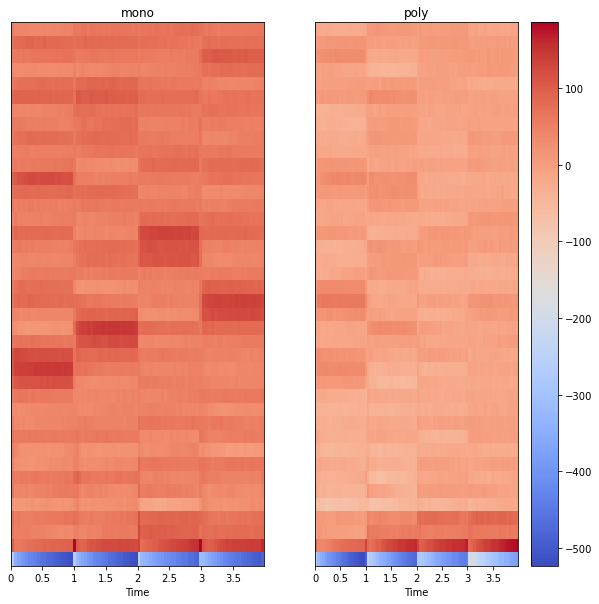

In [56]:
y, sr = librosa.load("notes.wav", sr=None, mono=True)
mfcc_mono = librosa.feature.mfcc(y, sr, n_fft=FRAME_SIZE, n_mfcc=40, hop_length=HOP_SIZE, center=False, fmax=F_MAX)
y, sr = librosa.load("chords.wav", sr=None, mono=True)
mfcc_poly = librosa.feature.mfcc(y, sr, n_fft=FRAME_SIZE, n_mfcc=40, hop_length=HOP_SIZE, center=False, fmax=F_MAX)

fig, axs = plt.subplots(1, 2)
mono_img = librosa.display.specshow(mfcc_mono, x_axis='time', hop_length=HOP_SIZE, sr=sr, fmax=F_MAX, ax=axs[0])
poly_img = librosa.display.specshow(mfcc_poly, x_axis='time', hop_length=HOP_SIZE, sr=sr, fmax=F_MAX, ax=axs[1])
# fig.colorbar(mono_img, ax=axs[0])
fig.colorbar(poly_img, ax=axs[1])
axs[0].set(title='mono')
axs[1].set(title='poly')

[Text(0.5, 1.0, 'poly')]

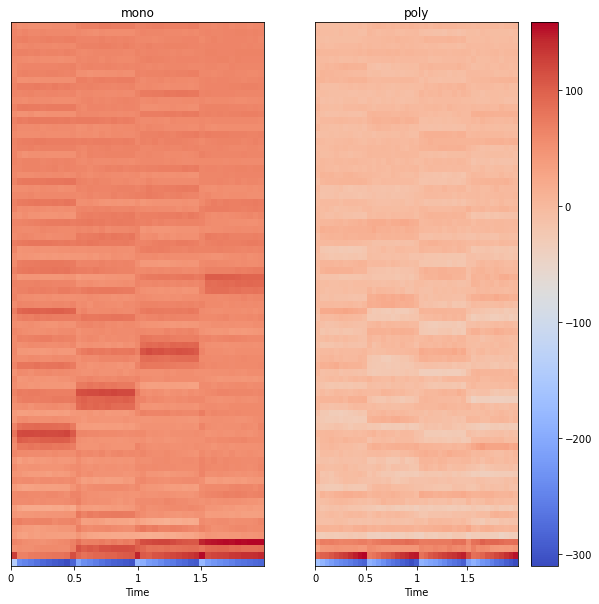

In [65]:
y, sr = librosa.load("ebgd.wav", sr=None, mono=True)
mfcc_mono = librosa.feature.mfcc(y, sr, n_fft=FRAME_SIZE, n_mfcc=80, hop_length=HOP_SIZE, center=False, fmax=F_MAX)
y, sr = librosa.load("ebgd_chord.wav", sr=None, mono=True)
mfcc_poly = librosa.feature.mfcc(y, sr, n_fft=FRAME_SIZE, n_mfcc=80, hop_length=HOP_SIZE, center=False, fmax=F_MAX)

fig, axs = plt.subplots(1, 2)
mono_img = librosa.display.specshow(mfcc_mono, x_axis='time', hop_length=HOP_SIZE, sr=sr, fmax=F_MAX, ax=axs[0])
poly_img = librosa.display.specshow(mfcc_poly, x_axis='time', hop_length=HOP_SIZE, sr=sr, fmax=F_MAX, ax=axs[1])
fig.colorbar(poly_img, ax=axs[1])
axs[0].set(title='mono')
axs[1].set(title='poly')

[Text(0.5, 1.0, 'poly')]

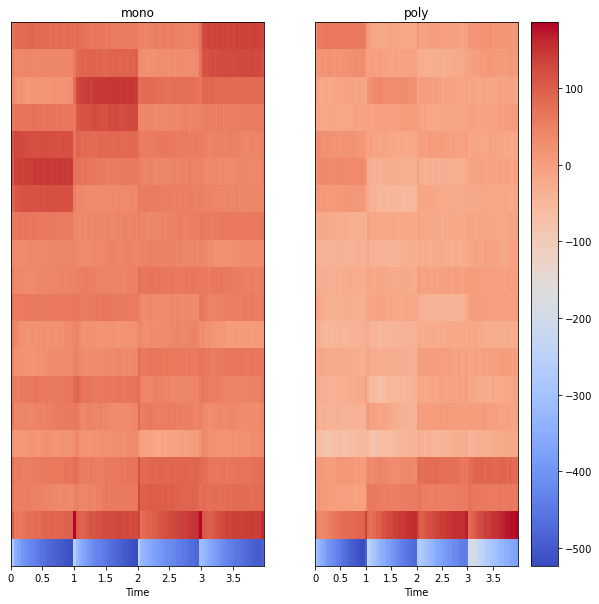

In [54]:
y, sr = librosa.load("notes.wav", sr=None, mono=True)
mfcc_mono = librosa.feature.mfcc(y, sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, center=False, fmax=F_MAX)
y, sr = librosa.load("chords.wav", sr=None, mono=True)
mfcc_poly = librosa.feature.mfcc(y, sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, center=False, fmax=F_MAX)

fig, axs = plt.subplots(1, 2)
mono_img = librosa.display.specshow(mfcc_mono, x_axis='time', hop_length=HOP_SIZE, sr=sr, fmax=F_MAX, ax=axs[0])
poly_img = librosa.display.specshow(mfcc_poly, x_axis='time', hop_length=HOP_SIZE, sr=sr, fmax=F_MAX, ax=axs[1])
fig.colorbar(poly_img, ax=axs[1])
axs[0].set(title='mono')
axs[1].set(title='poly')

[Text(0.5, 1.0, 'poly')]

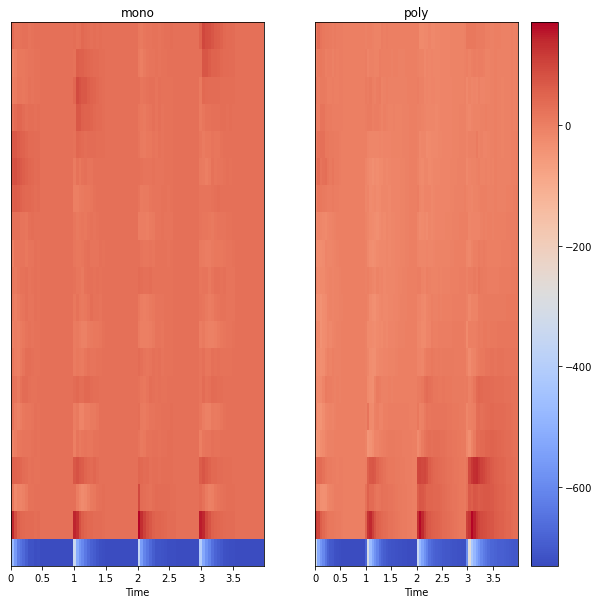

In [55]:
y, sr = librosa.load("mute_notes.wav", sr=None, mono=True)
mfcc_mono = librosa.feature.mfcc(y, sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, center=False, fmax=F_MAX)
y, sr = librosa.load("mute_chords.wav", sr=None, mono=True)
mfcc_poly = librosa.feature.mfcc(y, sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, center=False, fmax=F_MAX)

fig, axs = plt.subplots(1, 2)
mono_img = librosa.display.specshow(mfcc_mono, x_axis='time', hop_length=HOP_SIZE, sr=sr, fmax=F_MAX, ax=axs[0])
poly_img = librosa.display.specshow(mfcc_poly, x_axis='time', hop_length=HOP_SIZE, sr=sr, fmax=F_MAX, ax=axs[1])
fig.colorbar(poly_img, ax=axs[1])
axs[0].set(title='mono')
axs[1].set(title='poly')

### Mono F0 estimation confidence
Essentia provides PitchYin that returns a confidence value for each frame. Models were trained on the confidence values as the feature. The models were run on Colab and did not achieve satisfactory results. 

## Train sklearn classifier
**Run the training on Colab or CC. Do not train on local machine.**

Models trained on MFCC features have much better performance than those trained on Mel-spectra. Below shows the code used for training and testing the SVC models. 

RBFSVM always yielded better result than linear models, even when using less training data. 
| Features      | Linear (LR, SVM) | SVC(RBF)
| ----------- | -----------        | -----------
| Mel-spectrum| ~70%               | ~90%
| MFCC        | ~82%               | ~98%

In [44]:
mono = np.load("/content/drive/MyDrive/THESIS CODE/mono_mfcc_40.npz")
poly = np.load("/content/drive/MyDrive/THESIS CODE/poly_mfcc_40.npz")
print(mono.files)
print(poly.files)

['arr_0']
['arr_0']


In [ ]:
# load the features and labels
with np.load("/content/drive/MyDrive/THESIS CODE/mono_mfcc_40.npz") as data:
    mono = data["arr_0"]
print(mono.shape)
with np.load("/content/drive/MyDrive/THESIS CODE/poly_mfcc_40.npz") as data:
    poly = data["arr_0"]
print(poly.shape)

data = np.concatenate((mono, poly), axis=1)
print(data.shape)

X = data[:-1, :]
X = X.transpose()   # transpose so that X and y have the same size on the first dimension 
print(X.shape)
y = data[-1, :]
print(y.shape)

In [61]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
# from sklearn.utils import shuffle

In [ ]:
# use 80% as development set, 20% as evaluation set
X_dev, X_eval, y_dev, y_eval = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [ ]:
# normal cv, display multiple scoring metrics
pipe = make_pipeline(StandardScaler(), SVC())
scoring = ["accuracy", "precision", "recall", "f1"]
results = cross_validate(pipe, X_dev[:10000], y_dev[:10000], cv=5, n_jobs=-1, scoring=scoring, return_estimator=True)
results

In [ ]:
# grid search cv, find best hyperparameters, use only one metric
svc = make_pipeline(StandardScaler(), SVC())
param_grid = {
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", "auto"]
    }
search = GridSearchCV(svc, param_grid, scoring="f1", n_jobs=-1, refit=True, cv=3)
search.fit(X_dev[:100000], y_dev[:100000])
print("------------BEST_PARAMS--------")
print(search.best_params_)
print("------------BEST_SCORE---------")
print(search.best_score_)
print("------------EVAL_DATA----------")
y_pred = search.predict(X_eval)
print(accuracy_score(y_eval, y_pred))
print(f1_score(y_eval, y_pred))

In [ ]:
# final training on the entire training set, using the best params combination from grid search
svc = make_pipeline(StandardScaler(), SVC(C=10, gamma="scale"))
svc = svc.fit(X_dev, y_dev)
print("------------EVAL_DATA----------")
y_pred = svc.predict(X_eval)
print(accuracy_score(y_eval, y_pred))
print(f1_score(y_eval, y_pred))
# this was run on CC for ~8h, result: 
# Accu: 0.9922869574445505
# F1: 0.9917375665610179